# Part 4: Depth from Video -- Basic:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
import random
import gco
import os
import datetime
import scipy
import json

## read and load Camera parameter

In [2]:
# load current directory
cur_dir = os.path.dirname(os.path.abspath("CA2_Part4.ipynb"))
# Road directory
Road_dir = cur_dir + '/Road'
# load cameras.txt
cameras_dir = Road_dir + '/cameras.txt'
data = []
with open(cameras_dir, "r") as f: 
    data = f.readlines()

camera = []
for lines in data:
    if lines != '\n':
        lines = lines.strip('\n')
        lines = lines.split('\t')
        l = [float(i) for i in lines[:3]]
        camera.append(l)

camera = np.array(camera[1:])
K = []
R = []
T = []
for i in range(141):
    SMF = camera[i * 7:i * 7 + 7,:]
    Ki = SMF[:3]
    Ri = SMF[3:6]
    Ti = SMF[-1]
    K.append(Ki)
    R.append(Ri)
    T.append(Ti)

In [3]:
def parameter(frame):
    K1 = np.array(K[frame])
    R1 = np.array(R[frame])
    T1 = np.mat(T[frame]).T
    invK1 = linalg.inv(K1) 
    return K1,invK1,R1,T1

In [4]:
# distance
def distance(xi,xj):
    return np.sum(np.abs(xi - xj),axis = 1)/3/100

In [5]:
# get lambda(x,y)
def get_lambda(img):
    
    img = np.array(img)
    [row,col,_] = img.shape
    length = row * col
    index = np.array(range(length)).reshape(row,col)
    
    # neighbors 
    [up]  = index[:-1,:].reshape(1,-1)
    [down] = index[1:,:].reshape(1,-1)
    [left] = index[:,:-1].reshape(1,-1)
    [right] = index[:,1:].reshape(1,-1)

    # matches 
    x = np.concatenate((up,down,left,right), axis = 0)
    y = np.concatenate((down,up,right,left), axis = 0)

    # RGB of the image
    img = np.array(IMG[0])
    [red] = img[:,:,0].reshape(1,-1)
    [green] = img[:,:,1].reshape(1,-1)
    [blue] = img[:,:,2].reshape(1,-1)

    # weights
    r = (red[x[i]] - red[y[i]]) ** 2
    g = (green[x[i]] - green[y[i]]) ** 2
    b = (blue[x[i]] - blue[y[i]]) ** 2
    weight = 1 / (np.sqrt(r + g + b) + epsilon)
    
    # prior term: set pairwise aka smoothness weight
    ulambda = Nx / np.sum(weight)
    lambdaXY = ws * ulambda[0,x] * weight
    pairwise = scipy.sparse.coo_matrix((lambdaXY,(x,y)),shape = (length,length))
    
    return pairwise

## read and load images

In [6]:
# src directory
src_dir = Road_dir + '/src'
# read the img in src folder
img_list = os.listdir(src_dir)
# read images
IMG = []
for img_name in img_list:
    if img_name == '.DS_Store':
        continue
    img_path = src_dir + '/' + img_name
    im = cv2.imread(img_path,cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    IMG.append(im.tolist())

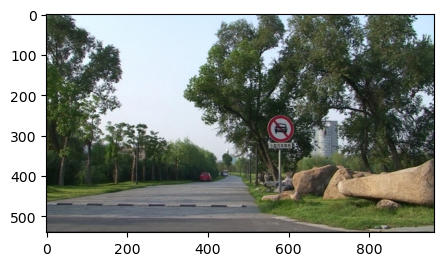

In [7]:
plt.figure( figsize=(5,5) )
plt.imshow(IMG[0])

### Set the parameter of the model

In [8]:
disparity = np.arange(0.0001,0.01,0.0002)
depth = len(disparity)
epsilon = 50
eta = 0.05 * (disparity[-1] - disparity[0])
ws = 20 / (disparity[-1] - disparity[0])
sigmaC = 10
# number of imgs used
num_img_used = 6
# labelcost
a, b = np.meshgrid(disparity,disparity)
labelcost = np.abs(a - b)
labelcost[labelcost > eta] = eta * np.ones(len(labelcost[labelcost > eta]))

# get the epipolar line
[row,col,c] = np.array(IMG[0]).shape
x = range(col)
y = range(row)
xx, yy = np.meshgrid(x, y)
xx = xx.reshape(1,-1)
yy = yy.reshape(1,-1)
N_sample = len(xx[0])
Xh = np.concatenate((xx,yy,np.ones([1,N_sample])),axis = 0)

# get Nx
Nx = 4 * np.ones([row,col])
Nx[1,-1] -= 1
Nx[:,[1,-1]] -= 1
Nx = Nx.reshape(1,-1)

# gco directory
gco_dir = Road_dir + '/gco'

## Process all 141 images

### Initial optimize

In [ ]:
for idx1 in range(141):

    # get image
    img1 = np.array(IMG[idx1])
    pixel_value1 = img1.reshape(1,-1,3)[0].T
    # get camera parameter
    K1,invK1,R1,T1 = parameter(idx1)
    # get prior term fp:
    pairwise = get_lambda(img1)

    # set the index range of another image
    img2index = np.arange(idx1 - num_img_used/2, idx1 + num_img_used/2, 1)
    img2index = [int(index) for index in img2index if index >= 0 and index < 141]

    # initialize the unary
    unary = np.zeros([depth,N_sample])

    tic = datetime.datetime.now()

    # get data term
    for idx2 in img2index:

        print('Processing No.%d'%idx1+' - No.%d'%idx2+'images')
        # get image
        img2 = np.array(IMG[idx2])
        pixel_value2 = img2.reshape(1,-1,3)[0].T
        # get camera parameter
        K2,invK2,R2,T2 = parameter(idx2)

        part1 = K2.dot(R2.T).dot(R1).dot(invK1).dot(Xh)
        Pc = np.zeros([depth,N_sample])
        for dl in range(depth):
            d = disparity[dl]
            Xh1 = Xh[0:2]
            part2 = d * K2.dot(R2.T).dot(T1 - T2)
            Xh2 = part1 + part2
            Xh2 = Xh2 / Xh2[2,:]
            Xh2 = np.round(Xh2)

            # remove the point out of the image
            index1 = np.where(Xh2[0] >= col)[1]
            index2 = np.where(Xh2[0] < 0)[1]
            index3 = np.where(Xh2[1] >= row)[1]
            index4 = np.where(Xh2[1] < 0)[1]
            index = np.union1d(index1,index2)
            index = np.union1d(index,index3)
            index = np.union1d(index,index4)
            for i in index:
                Xh2[:,i] = np.mat(Xh[:,i]).T

            # calculate the difference
            IM1 = pixel_value1
            IM2 = pixel_value2
            Xh3 = Xh2[0:2]
            order = np.array([k*col + j  for [j,k] in Xh3.T.tolist()]).astype(int)
            IM1[:,index] = np.zeros([3,len(index)])
            IM2 = IM2[:,order]
            IM2[:,index] = np.zeros([3,len(index)])
            diff = distance(IM1.T,IM2.T)
            avg = np.sum(diff) / (len(diff) - len(index))
            diff[index] = avg

            # store in unary
            Pc[dl] = sigmaC / (sigmaC + diff)

        unary += Pc

    toc = datetime.datetime.now()
    print('Elapsed time: %f seconds' % (toc-tic).total_seconds())

    # normalize dataterm
    unary = 1 - unary / np.max(unary,axis = 1)

    # run graph cut
    tic = datetime.datetime.now()
    print('GCO running')

    gc = gco.GCO()
    gc.create_general_graph(N_sample, depth)
    gc.set_data_cost(unary.T)
    x = pairwise.row
    y = pairwise.col
    data = pairwise.data
    gc.set_all_neighbors(x,y,data)
    gc.set_smooth_cost(labelcost)
    print('start graph cut')
    gc.swap()

    labels = gc.get_labels()

    toc = datetime.datetime.now()
    print('Elapsed time: %f seconds' % (toc-tic).total_seconds())

    # json data store
    data_dir = gco_dir + '/image' + str(idx1)
    with open(data_dir,'w') as f:
        json.dump(labels.tolist(),f)

Processing No.0 - No.0images


# Bundle Optimization

In [28]:
idx1 = 2
# get image
img1 = np.array(IMG[idx1])
pixel_value1 = img1.reshape(1,-1,3)[0].T
# get camera parameter
K1,invK1,R1,T1 = parameter(idx1)
# get prior term fp:
pairwise = get_lambda(img1)

# set the index range of another image
img2index = np.arange(idx1 - 2, idx1 + 3, 1)
img2index = [int(index) for index in img2index if index >= 0 and index < 141]

# initialize the unary
unary = np.zeros([depth,N_sample])

tic = datetime.datetime.now()

# get data term
for idx2 in img2index:

    print('Processing No.%d'%idx1+' - No.%d'%idx2+'images')
    # get image
    img2 = np.array(IMG[idx2])
    pixel_value2 = img2.reshape(1,-1,3)[0].T
    # get camera parameter
    K2,invK2,R2,T2 = parameter(idx2)

    part1 = K2.dot(R2.T).dot(R1).dot(invK1).dot(Xh)
    Pc = np.zeros([depth,N_sample])
    Pv = np.zeros([depth,N_sample])
    for dl in range(depth):
        d = disparity[dl]
        Xh1 = Xh[0:2]
        part2 = d * K2.dot(R2.T).dot(T1 - T2)
        Xh2 = part1 + part2
        Xh2 = Xh2 / Xh2[2,:]
        Xh2 = np.round(Xh2)

        # remove the point out of the image
        index1 = np.where(Xh2[0] >= col)[1]
        index2 = np.where(Xh2[0] < 0)[1]
        index3 = np.where(Xh2[1] >= row)[1]
        index4 = np.where(Xh2[1] < 0)[1]
        index = np.union1d(index1,index2)
        index = np.union1d(index,index3)
        index = np.union1d(index,index4)
        for i in index:
            Xh2[:,i] = np.mat(Xh[:,i]).T

        # calculate the difference
        IM1 = pixel_value1
        IM2 = pixel_value2
        Xh3 = Xh2[0:2]
        order = np.array([k*col + j  for [j,k] in Xh3.T.tolist()]).astype(int)
        IM1[:,index] = np.zeros([3,len(index)])
        IM2 = IM2[:,order]
        IM2[:,index] = np.zeros([3,len(index)])
        diff = distance(IM1.T,IM2.T)
        avg = np.sum(diff) / (len(diff) - len(index))
        diff[index] = avg

        # store in unary
        Pc[dl] = sigmaC / (sigmaC + diff)
        
        # bundel optimization
        jsonfile = open(gco_dir + '/image' + str(idx2))
        img2label = json.load(jsonfile)
        
        d_img2 = np.mat(disparity[img2label])
        Xh1p = K2.dot(R2.T).dot(R1).dot(invK1).dot(Xh2) +  K2.dot(R2.T).dot(T1 - T2) * d_img2
        
        Xh1p = Xh1p / Xh1p[2]
        Xh1p = np.round(Xh1p)
        
        # squared euclidean distance
        dist = np.sum(np.multiply((Xh - Xh1p) , (Xh - Xh1p)),axis = 0)

        sigma_d = 2.5;
        Pv[dl] = np.exp(-dist / (2*sigma_d**2))
        

    unary += Pc*Pv

toc = datetime.datetime.now()
print('Elapsed time: %f seconds' % (toc-tic).total_seconds())

# normalize dataterm
unary = 1 - unary / np.max(unary)

# run graph cut
tic = datetime.datetime.now()
print('GCO running')

gc = gco.GCO()
gc.create_general_graph(N_sample, depth)
gc.set_data_cost(unary.T)
x = pairwise.row
y = pairwise.col
data = pairwise.data
gc.set_all_neighbors(x,y,data)
gc.set_smooth_cost(labelcost)
print('start graph cut')
gc.swap()

labels = gc.get_labels()

toc = datetime.datetime.now()
print('Elapsed time: %f seconds' % (toc-tic).total_seconds())

# json data store
data_dir = gco_dir + '/bundle' + str(idx1)
with open(data_dir,'w') as f:
    json.dump(labels.tolist(),f)

Processing No.2 - No.0images
Processing No.2 - No.1images
Processing No.2 - No.2images
Processing No.2 - No.3images
Processing No.2 - No.4images
Elapsed time: 202.078271 seconds
GCO running
start graph cut
Elapsed time: 1.272012 seconds


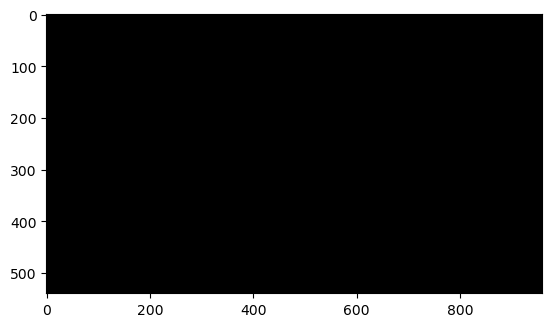

In [29]:
plt.imshow(labels.reshape(row,col),'gray')

In [32]:
print(labels[labels != 0])

[]


# All the labels are 0. There must be some bug in my program. But I have no time to debug now. :(

In [33]:
print(unary)

[[0.25545526 0.32657738 0.41225984 ... 0.32941555 0.26938676 0.19660387]
 [0.18061843 0.25027334 0.33564273 ... 0.25644334 0.30001684 0.15671052]
 [0.19243853 0.34676334 0.34070056 ... 0.21621245 0.25924776 0.1162048 ]
 ...
 [0.43782744 0.43734335 0.43271901 ... 0.40359475 0.42101133 0.42082911]
 [0.43787057 0.43738648 0.43276214 ... 0.40359689 0.42101015 0.42082811]
 [0.43788711 0.43740302 0.43277869 ... 0.40357598 0.42098923 0.42080719]]
